# The Graph
The underlying architecture used by Keisler 2022 is that of a message-passing Graph Neural Network ([Battaglia et al. 2018](    
https://doi.org/10.48550/arXiv.1806.01261), [Pfaff et al. 2022](https://arxiv.org/abs/2010.03409)), 
where phyiscal information at high resolution is transfered/mapped to a lower-resolution abstract space. Here the information is processed, after which the result is mapped back to the high resolution physical space to provide the forecast.  
- The mapping from the **physical space** to the **abstract representation** (often called the latent space) is done by the **Encoder**
- The processing in the **latent space** is done by the **Processor**
- The mapping from the **latent space** back to the physical space is done by the **Decoder**

The collection of connections through which information can flow:
- from the data grid to processor grid
- between the points during the processing 
- back to the decoder,
is called **the graph**

In [78]:
from pathlib import Path
import yaml
from anemoi.datasets import open_dataset
import anemoi.graphs.nodes as nodes
import anemoi.graphs.edges as edges
import anemoi.graphs.nodes.attributes as node_attributes
import anemoi.graphs.edges.attributes as edge_attributes
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

## Data Grid
In the physical space the data lives on the 2D - model grid. In our case this is (see previous chapter) a 1&deg; x 1&deg;  lon-lat grid.
We can visualize this grid using the previously built `anemoi-dataset`

In [79]:
PROJECT_ROOT = Path.cwd().parent

dataset_path = PROJECT_ROOT / "output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr"
ds = open_dataset(dataset_path)

The longitudes and latitudes of the gridpoints can be accessed trought the `longitudes` and `latitudes` attributes.
The 1&deg; x 1&deg; resolution is too fine to clearly visualize the gridoints globally so we focus on an reduced area.

Number of grid-points or data nodes: 65160


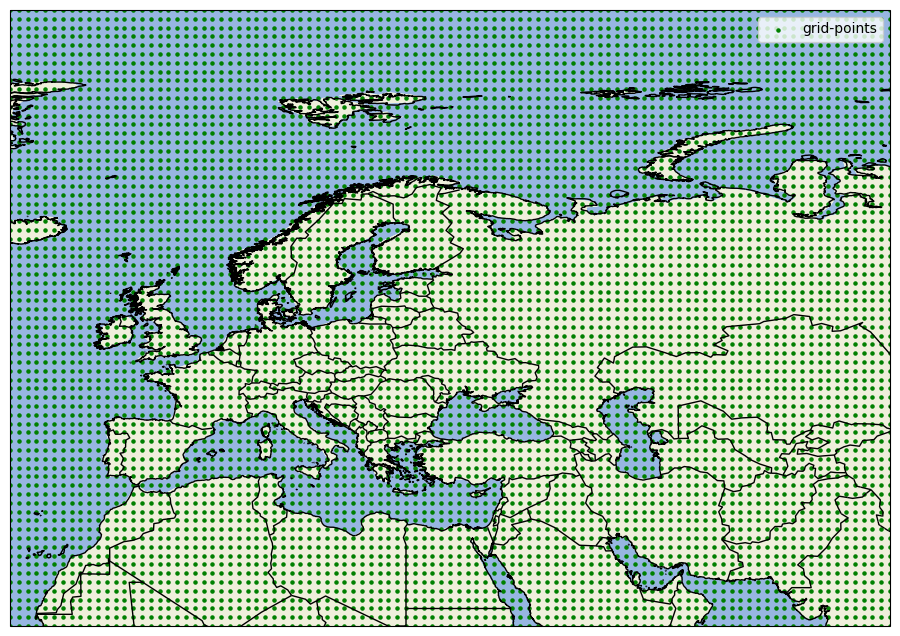

In [80]:
print("Number of grid-points or data nodes:", len(ds.latitudes))

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))
ax.scatter(ds.longitudes, ds.latitudes, s=5, c="green", label="grid-points")
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines(resolution="10m")
ax.set_extent([-20,80,20,90])
_ = ax.legend(loc="upper right")



In the Machine Learning world these grid points are typically referred to as **data nodes**

# Processor grid
The choice of lower-resolution grid used in the Processor is open. A popular choice is the icosahedron grid.  
This grid is defined by representing the sphere by hexagons or triangles. 
At the coarsest level (i.e. refinement level or resolution 0),  
the hexagonal refined icosahedral grid represents the earth sphere with ?? hexagons, leading to ?? grid points or nodes.

In Keisler 2022, a refinement level of 2 is chosen, resulting in 5882 points or processor nodes. 

This hexagonal refined icosahedral grid is supported by `anemoi-graphs` and the corresponding grid points can be generated.

In [81]:
from anemoi.graphs.generate.hex_icosahedron import create_hex_nodes

In [82]:
_, coords, ordering = create_hex_nodes(resolution=2)
coords = np.rad2deg(coords)

Number of icosahedral grid-points or processor nodes: 5882


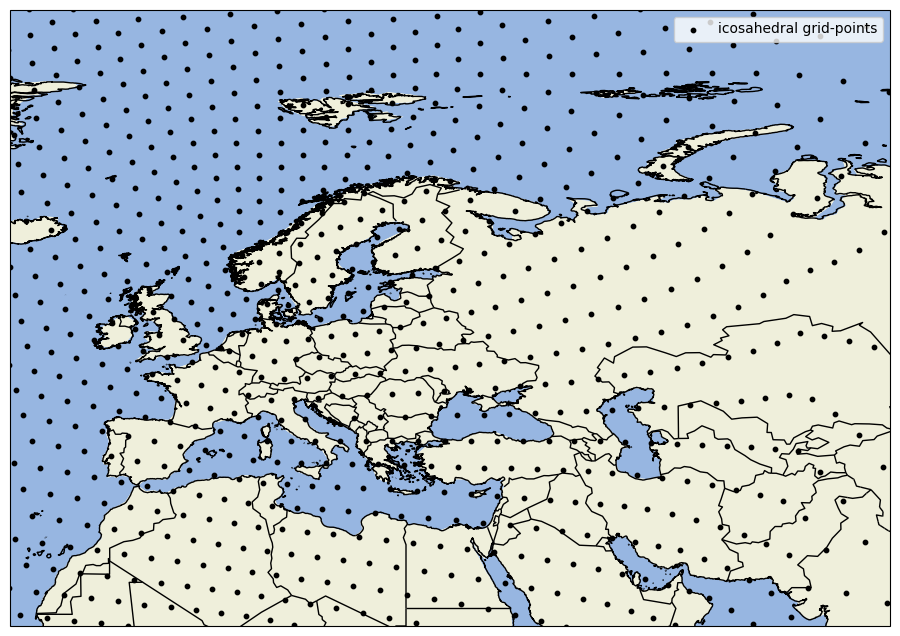

In [83]:
print("Number of icosahedral grid-points or processor nodes:", len(coords))
fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))
ax.scatter(coords[:,0], coords[:,1], s=10, c="black", label="icosahedral grid-points")
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines(resolution="10m")
ax.set_extent([-20,80,20,90])
_ = ax.legend(loc="upper right")

In the Machine Learning world these grid points in the intermedate state or processorer space are typically referred to as **processor nodes**

## Moving information between grids
The graph message parsing network moves/transfers/maps the physiscal data from the high resolution physical space to a, typically, lower resolution but higher dimensional abstract space. How information can travel between the physical grid and the processor grid and back is determined by defining a **bipartite** (i.e. all connections start in one collection and end in another one) **graph**. 

### Encoding
The transfer from the physical to the abstract space is called the encoding. The flow of information is determined by connecting each processor node with a certain number of data nodes.   
In Keisler 2022, the choice was made to connect each processor node with the 12 nearest data nodes.  
Below it is shown what this looks like for one processor node in the centre of our reduced domain.

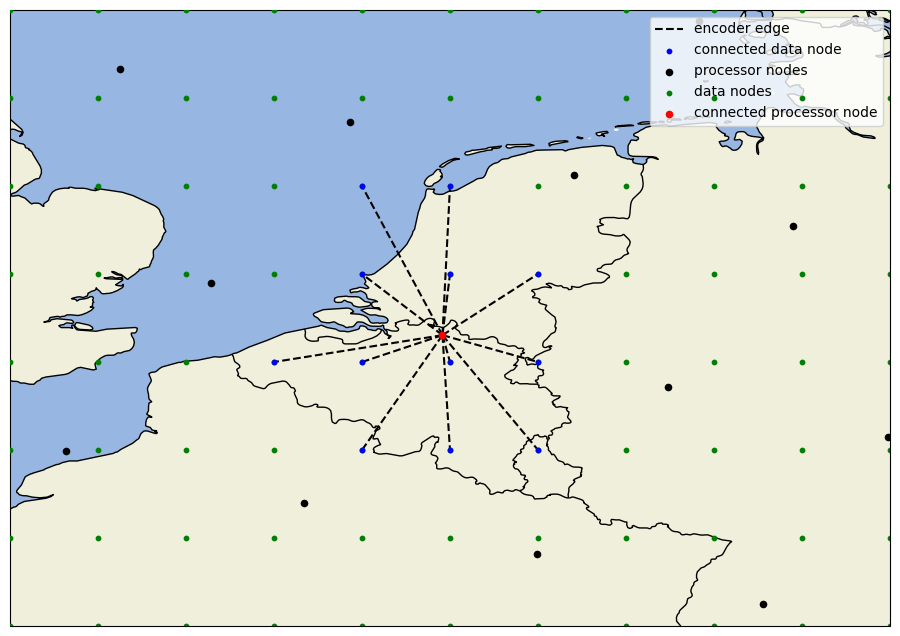

In [84]:
# Set the plotting extent
extent = [0,10,48,55]
# Define the processor grid point in the centre
lon_mid = np.mean(extent[:2])
lat_mid = np.mean(extent[2:4])
i_centre = np.argmin(np.sqrt((coords[:,0]-lon_mid)**2+(coords[:,1]-lat_mid)**2))

# Find its 12 nearest neighbours.
# NOTE: Here the nearest neighbours are determined based on the coordinates, 
#       Ideally one should use the Haverside distance to correctly represent the distances on the globe.
knn = np.argsort(np.sqrt((ds.longitudes-coords[i_centre,0])**2+(ds.latitudes-coords[i_centre,1])**2))[:12]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))
# For each data nearest neighbour of the central processor node
for j in knn:
    # Plot the connection (edge) with label for the first one
    if j == knn[0]:
        ax.plot([coords[i_centre,0],ds.longitudes[j]], [coords[i_centre,1], ds.latitudes[j]], c="black",ls="--",zorder=15,label="encoder edge")
        ax.scatter(ds.longitudes[j], ds.latitudes[j], s=10, c="blue", zorder=20, label="connected data node")
    else:
        ax.plot([coords[i_centre,0],ds.longitudes[j]], [coords[i_centre,1], ds.latitudes[j]], c="black",ls="--",zorder=15)
        ax.scatter(ds.longitudes[j], ds.latitudes[j], s=10, c="blue", zorder=20)
    

# Plot all processor nodes
ax.scatter(coords[:,0], coords[:,1], s=20, c="black",label="processor nodes")
# Plot all data nodes
ax.scatter(ds.longitudes, ds.latitudes, s=10, c="green", label="data nodes", zorder=15)
# Highlight the centre data node in red
ax.scatter(coords[i_centre,0],coords[i_centre,1],s=20,c="red",label="connected processor node", zorder=20)
# Add map features
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
# set the extent
ax.set_extent(extent)
_ = ax.legend(loc="upper right")


The connections used to encode the information from the data nodes to the processor nodes (dashed lines) are called the **encoder edges**

### Processing
During the processing information is exchanged between the neighbouring processor nodes. In Keisler 2022 each processor node is connected to each 6 nearest neighbours.  
An example of what this looks like is shown here:

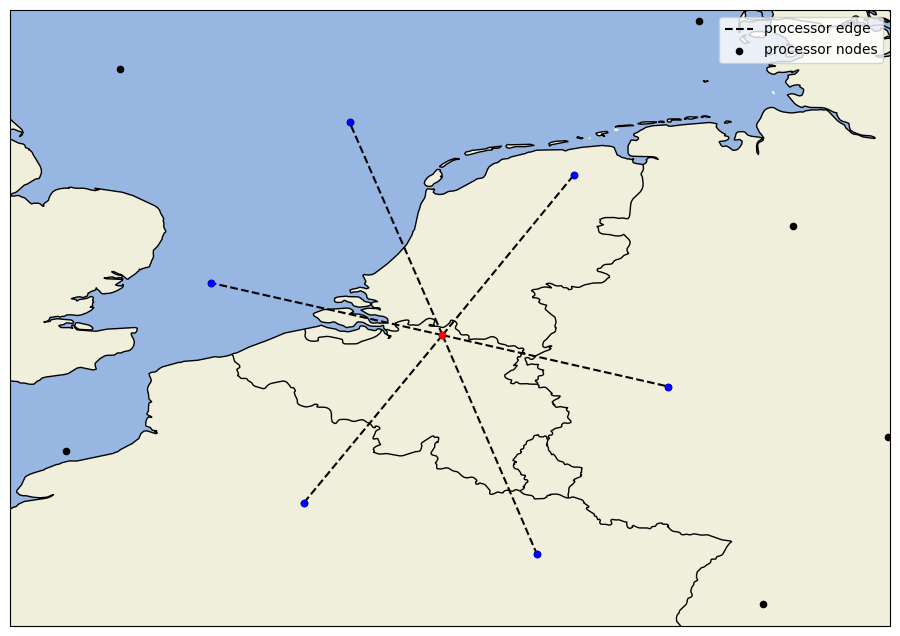

In [85]:
knn = np.argsort(np.sqrt((coords[:,0]-coords[i_centre,0])**2+(coords[:,1]-coords[i_centre,1])**2))[1:7]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))

for j in knn:
    if j == knn[0]:
        ax.plot([coords[i_centre,0], coords[j,0]], [coords[i_centre,1], coords[j,1]], c="black",ls="--",zorder=15,label="processor edge")
    else:
        ax.plot([coords[i_centre,0], coords[j,0]], [coords[i_centre,1], coords[j,1]], c="black",ls="--",zorder=15)
    ax.scatter(coords[j,0], coords[j,1], s=20, c="blue",zorder=15)
ax.scatter(coords[:,0], coords[:,1], s=20, c="black",label="processor nodes")
#ax.scatter(ds.longitudes, ds.latitudes, s=10, c="green", label="data nodes")
ax.scatter(coords[i_centre,0],coords[i_centre,1],s=20,c="red",zorder=20)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_extent([0,10,48,55])
ax.legend()


Similar to the encoder above, these connection (dashed lines) are called the **processor edges**.

### Decoding
Finally, to make a sensible weather prediction, we need to map the information again to the interpretatable atmospheric variables on the higher-resolution grid.  
This is done by moving the information from the processor nodes back to the data nodes, by connection each data node to the 3 nearest processor nodes:

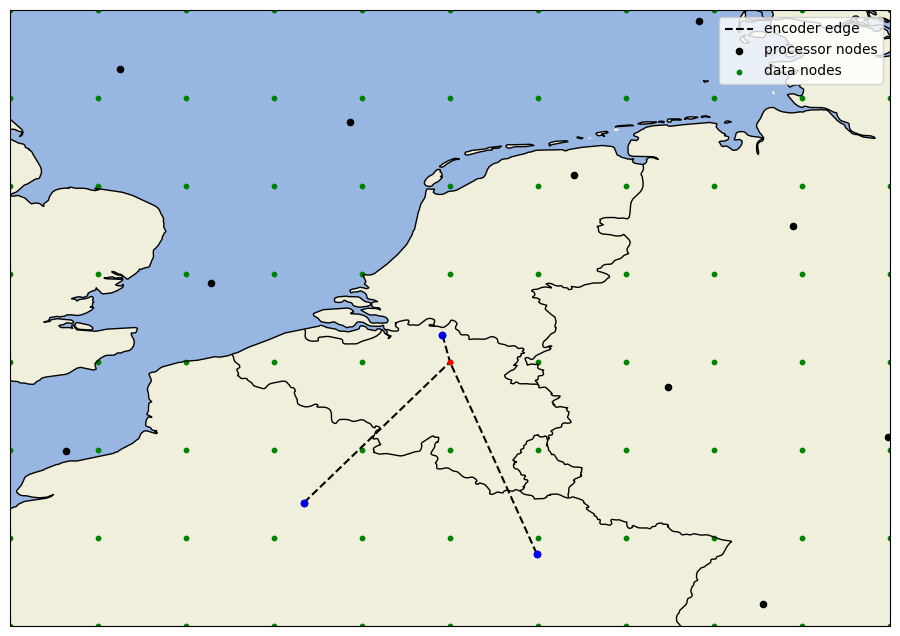

In [86]:
i_centre = np.argmin(np.sqrt((ds.longitudes-lon_mid)**2+(ds.latitudes-lat_mid)**2))
knn = np.argsort(np.sqrt((ds.longitudes[i_centre]-coords[:,0])**2+(ds.latitudes[i_centre]-coords[:,1])**2))[:3]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))

for j in knn:
    if j == knn[0]:
        ax.plot([coords[j,0],ds.longitudes[i_centre]], [coords[j,1], ds.latitudes[i_centre]], c="black",ls="--",zorder=15,label="encoder edge")
    else:
        ax.plot([coords[j,0],ds.longitudes[i_centre]], [coords[j,1], ds.latitudes[i_centre]], c="black",ls="--",zorder=15)
    ax.scatter(coords[j,0], coords[j,1], s=20, c="blue", zorder=15)
ax.scatter(coords[:,0], coords[:,1], s=20, c="black",label="processor nodes")
ax.scatter(ds.longitudes, ds.latitudes, s=10, c="green", label="data nodes")
ax.scatter(ds.longitudes[i_centre], ds.latitudes[i_centre],s=10,c="red",zorder=20)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_extent([0,10,48,55])
ax.legend()

Again, these connections are called the **decoder edges**

## Using `anemoi-graphs`
Defining all these nodes and the connections between them to create the graph uses during the message-passing can be automated using [`anemoi-graphs`](https://anemoi.readthedocs.io/projects/graphs).  
Similar to `anemoi-datasets`, `anemoi-graphs` provides a simple high-level interface based on a YAML recipe file, which can be used to build graphs for the input, hidden and output layers. For each layer, the package allows you to:
- Define graph nodes based on coordinates defined in a dataset (anemoi dataset and NPZ) or via algorithmic approaches.
- Define edges (connections between nodes) based on different methods.
- Define attributes of nodes and edges.  

The specification of each layer is defined using a YAML file, which is run via the command-line tool. The command-line tool allows you to quickly create graphs, for example:
```bash
anemoi-graphs create recipe.yaml graph.pt
```


### The `YAML` recipe file
The recipe files exist out of 2 main components and is organized as a python nested dictionary:
1. **Nodes**, defining the different nodes in the graph. Each entry here is another dictionary where the keys are the names of the sets of nodes that will later be used to build the connections. Each corresponding value defines the nodes configuration and must include a node_builder section describing how to define the nodes.
2. **Edges**, defining the connections between the different nodes. Connections are created independently for each *(source name, target name)* pair specified and should enter the dictionary entry as a list. 

In [87]:
# Define the main keys of the graph-recipe
recipe_keys = [
    "nodes",
    "edges",
]
# Build the recipe skeleton
recipe = dict.fromkeys(recipe_keys)

# Different node-types are defined as entries to a dictionary
recipe["nodes"] = dict()

# Different edge-types are defined through elements in a list
recipe["edges"] = list()

recipe

{'nodes': {}, 'edges': []}

### Defining nodes
`anemoi-graphs` can build nodes in many different ways. As explained above, nodes can be build based on the grid points of a specific dataset or can be build using algorithmic approaches.  
An overview of the different node builders available is shown below and more information about them can be found [here](https://anemoi.readthedocs.io/projects/graphs/en/latest/graphs/node_coordinates.html).

In [88]:
print("Possible node builders are:")
for builder in nodes.__all__:
    print(f"  - {builder}")


Possible node builders are:
  - AnemoiDatasetNodes
  - NPZFileNodes
  - TriNodes
  - HexNodes
  - HEALPixNodes
  - LatLonNodes
  - LimitedAreaHEALPixNodes
  - LimitedAreaNPZFileNodes
  - LimitedAreaTriNodes
  - LimitedAreaHexNodes
  - ReducedGaussianGridNodes
  - StretchedTriNodes
  - ICONMultimeshNodes
  - ICONCellGridNodes
  - ICONNodes
  - TextNodes
  - XArrayNodes


In Keisler 2022, two types of nodes are defined.  

1. The **data nodes**.   
These nodes coincide with the grid points of our data. To derive the data nodes from our previously built `anemoi-dataset` the `node_builder` can be provided with  anemoi-graphs's `AnemoiDatasetNodes` and the path of our dataset:

In [89]:
data_nodes = {
    "node_builder": {
        "_target_": "anemoi.graphs.nodes.AnemoiDatasetNodes",
        "dataset": str(dataset_path),
    },
}
recipe["nodes"]["data"] = data_nodes
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}}},
 'edges': []}

2. The **processor** nodes.  
These nodes define the *lower*-resolution nodes used by the processor part of the network. Keisler 2022 uses the nodes of a sphere represented as hexagonal refined icosahedral with refinement level 2. To derive these nodes the `node_builder` can be provided with  anemoi-graphs's `HexNodes` and the refinement level:

In [90]:
processor_nodes = {
    "node_builder": {
        "_target_": "anemoi.graphs.nodes.HexNodes",
        "resolution": 2,
    }
}
recipe["nodes"]["processor"] = processor_nodes
recipe


{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': []}

### Defining Edges
`anemoi-graphs` can connect nodes using multiple algoritmic approaches.  
An overview of the different edge builders available is shown below and more information about them can be found [here](https://anemoi.readthedocs.io/projects/graphs/en/latest/graphs/edges.html).  
Next to the edge builder itself, anemoi-graph needs to know what the source and target nodes of the edges are. This is specified through the `source_name` and `target_name` entries in the dictionary describing a specific edge type. These names in turn must refer to the names (dictionary-keys) used in the nodes section. In our case either `data` or `processor`

In [91]:
print("Possible edge builders are:")
for builder in edges.__all__:
    print(f"  - {builder}")

Possible edge builders are:
  - KNNEdges
  - CutOffEdges
  - MultiScaleEdges
  - ReversedCutOffEdges
  - ReversedKNNEdges
  - ICONTopologicalProcessorEdges
  - ICONTopologicalEncoderEdges
  - ICONTopologicalDecoderEdges


Let's define the three type of edges used in Keisler 2022:
1. **Encoder edges** connecting the data nodes to the processor nodes using the 12 nearest neighbours. 
In practice this results to defining a dictionary where the `source_name` is set to `data`, the `target_name` is set to `processor` and providing the `edge_builder` with `anmeoi-graphs`' `KNNEdges` and the `num_nearest_neighbours`:

In [92]:
encoder = {
    "source_name": "data",
    "target_name": "processor",
    "edge_builder": {
        "_target_": "anemoi.graphs.edges.KNNEdges",
        "num_nearest_neighbours": 12,
    }
}


This dictionary can then be appended to the list of edges:

In [93]:
recipe["edges"].append(encoder)
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}}]}

2. **Processor edges** connecting the a processor nodes to its 6 nearest neighbours:

In [94]:
processor = {
    "source_name": "processor",
    "target_name": "processor",
    "edge_builder": {
        "_target_": "anemoi.graphs.edges.KNNEdges",
        "num_nearest_neighbours": 6,        
    }
}

recipe["edges"].append(processor)
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}}]}

3. **Decoder edges** connecting the data nodes to their 3 nearest processor nodes:

In [95]:
decoder = {
    "source_name": "processor",
    "target_name": "data",
    "edge_builder": {
        "_target_": "anemoi.graphs.edges.KNNEdges",
        "num_nearest_neighbours": 3
    }
}
recipe["edges"].append(decoder)
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3}}]}

## Attributes

Finally, each node and edge can contain additional attributes. These attributes can be usefull for different use-cases, they can be used as additional features for the network (think of edge length end direction) or can be used in the loss function (think of a weight per node) or can be used to mask certain nodes (think of land variables over sea). 

1. **Node attributes**  
An overview of all available node attributes is shown below. More information about the different node attributes can be found [here](https://anemoi.readthedocs.io/projects/graphs/en/latest/graphs/node_attributes.html).


In [96]:
print("Available node attributes are:")
for attr in node_attributes.__all__:
    print(f"  - {attr}")
print("")


Available node attributes are:
  - GridsMask
  - SphericalAreaWeights
  - PlanarAreaWeights
  - UniformWeights
  - CutOutMask
  - MaskedPlanarAreaWeights
  - NonmissingAnemoiDatasetVariable
  - NonzeroAnemoiDatasetVariable
  - BooleanAndMask
  - BooleanNot
  - BooleanOrMask
  - CosineLatWeightedAttribute
  - IsolatitudeAreaWeights



In Keisler 2022, the loss is averaged over all grid point by scaling it using a weight proporational to each grid point's area.  
In a regular lat-lon grid as used here, this is equivalent to weighing each pixel by the *cosine* of its latitude. 
To achieve this, an additional `attributes` key can be provided to the data nodes entry in the recipe:

In [97]:
recipe["nodes"]["data"]["attributes"] = dict()
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3}}]}

and the attributes dictionary can be populated by the different `anemoi-graph` node attributes. In our case, the `CosineLatWeightedAttribute` is used.  
The attribute can then later be used by refering to the key name (here `weights`):

In [98]:
# Define the weight attribute
weight_attribute = {
    "_target_": "anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute",
    "norm": "unit-max"
}

# Add it to the attributes dictionary in the recipe, under the weights key
recipe["nodes"]["data"]["attributes"]["weights"] = weight_attribute
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {'weights': {'_target_': 'anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute',
     'norm': 'unit-max'}}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3}}]}

2. **Edge attributes**
The Graph Message-Passing Network, uses information about the edge length and edge direction of the different connections. For this info to be available to the network we need to add it to the edges as attributes. Similarly to the nodes, this can be done by adding an attributes key, holding a dictionary to each edge type:


In [99]:
for edge_type in recipe["edges"]:
    edge_type["attributes"] = dict()
recipe

{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {'weights': {'_target_': 'anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute',
     'norm': 'unit-max'}}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12},
   'attributes': {}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6},
   'attributes': {}},
  {'source_name': 'processor',
   'target_name': 'data',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 3},
   'att

Edge length and direction can be calculated using the `anemoi-graphs` `EdgeLength` and `EdgeDirection` edge attributes respectively:

In [100]:
edge_length = {"_target_": "anemoi.graphs.edges.attributes.EdgeLength"}
edge_direction = {"_target_": "anemoi.graphs.edges.attributes.EdgeDirection"}


These attributes can then be added to the respective edges. Again the attributes can then be used later using their respective dictionary keys. In this case `edge_length` and `edge_direction`.

In [101]:
for edge_type in recipe["edges"]:
    edge_type["attributes"]["edge_length"] = edge_length
    edge_type["attributes"]["edge_direction"] = edge_direction

recipe


{'nodes': {'data': {'node_builder': {'_target_': 'anemoi.graphs.nodes.AnemoiDatasetNodes',
    'dataset': '/scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr'},
   'attributes': {'weights': {'_target_': 'anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute',
     'norm': 'unit-max'}}},
  'processor': {'node_builder': {'_target_': 'anemoi.graphs.nodes.HexNodes',
    'resolution': 2}}},
 'edges': [{'source_name': 'data',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 12},
   'attributes': {'edge_length': {'_target_': 'anemoi.graphs.edges.attributes.EdgeLength'},
    'edge_direction': {'_target_': 'anemoi.graphs.edges.attributes.EdgeDirection'}}},
  {'source_name': 'processor',
   'target_name': 'processor',
   'edge_builder': {'_target_': 'anemoi.graphs.edges.KNNEdges',
    'num_nearest_neighbours': 6},
   'attributes': {'edge_leng

Let's see now what the final recipe `yaml` looks like

In [102]:
print(
    yaml.dump(
        recipe,
        default_flow_style=False,
        sort_keys=False
    )
)

nodes:
  data:
    node_builder:
      _target_: anemoi.graphs.nodes.AnemoiDatasetNodes
      dataset: /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr
    attributes:
      weights:
        _target_: anemoi.graphs.nodes.attributes.CosineLatWeightedAttribute
        norm: unit-max
  processor:
    node_builder:
      _target_: anemoi.graphs.nodes.HexNodes
      resolution: 2
edges:
- source_name: data
  target_name: processor
  edge_builder:
    _target_: anemoi.graphs.edges.KNNEdges
    num_nearest_neighbours: 12
  attributes:
    edge_length: &id001
      _target_: anemoi.graphs.edges.attributes.EdgeLength
    edge_direction: &id002
      _target_: anemoi.graphs.edges.attributes.EdgeDirection
- source_name: processor
  target_name: processor
  edge_builder:
    _target_: anemoi.graphs.edges.KNNEdges
    num_nearest_neighbours: 6
  attributes:
    edge_length: *id001
    edge_direction: *id002
- source_name:

In [103]:
recipe_dir = PROJECT_ROOT / "configs/graphs"
recipe_dir.mkdir(parents=True, exist_ok=True)
recipe_path = str(recipe_dir / "era5-360x181equiangularwithpolesconservative-hexnodes.yaml")
with open(recipe_path, 'w') as file:
    yaml.dump(recipe, file, default_flow_style=False, sort_keys=False)

In [104]:
graph_dir = PROJECT_ROOT / "output/graphs"
graph_dir.mkdir(parents=True, exist_ok=True)
graph_path = str(graph_dir / "era5-360x181equiangularwithpolesconservative-hexnodes.pt")

In [105]:
!anemoi-graphs create --overwrite {recipe_path} {graph_path}

2025-10-23 19:09:11 INFO Reading the dataset from /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/datasets/keisler-era5-gs-weatherbench2-1p0d-1979-1979-3h-v0.zarr.
2025-10-23 19:09:12 INFO Using KNN-Edges (with 12 nearest neighbours) between data and processor.
2025-10-23 19:09:14 INFO Using KNN-Edges (with 6 nearest neighbours) between processor and processor.
2025-10-23 19:09:14 INFO Using KNN-Edges (with 3 nearest neighbours) between processor and data.
2025-10-23 19:09:14 INFO Cleaning graph.
2025-10-23 19:09:14 INFO _grid_reference_distance deleted from graph.
2025-10-23 19:09:14 INFO _dataset deleted from graph.
2025-10-23 19:09:14 INFO _grid_reference_distance deleted from graph.
2025-10-23 19:09:14 INFO _resolutions deleted from graph.
2025-10-23 19:09:14 INFO _node_ordering deleted from graph.
2025-10-23 19:09:14 INFO _nx_graph deleted from graph.
2025-10-23 19:09:14 INFO Graph saved at /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/graphs/era5-360

In [106]:
!anemoi-graphs inspect {graph_path} {graph_dir}


📦 Path       : /scratch/mch/fzanetta/projects/anemoi-demo-keisler2022/output/graphs/era5-360x181equiangularwithpolesconservative-hexnodes.pt
💽 Size       : 6.5 MiB (6856096)

🪩  Nodes summary

   Nodes name │ Num. nodes │ Attributes │ Attribute dim │ Min. latitude │ Max. latitude │ Min. longitude │ Max. longitude
   ───────────┼────────────┼────────────┼───────────────┼───────────────┼───────────────┼────────────────┼───────────────
   data       │      65160 │    weights │             1 │           -90 │            90 │              0 │            359
   processor  │       5882 │            │             0 │      -89.2415 │       89.2415 │       -179.975 │        179.939
   ───────────┴────────────┴────────────┴───────────────┴───────────────┴───────────────┴────────────────┴───────────────


🌐  Edges summary

   Source    │ Target    │ Num. edges │ Isolated Source │ Isolated Target │ Attribute dim │                          Attributes
   ──────────┼───────────┼────────────┼─────────

In [107]:
import torch

In [108]:
graph = torch.load(graph_path, weights_only=False)


In [109]:
graph

HeteroData(
  data={
    x=[65160, 2],
    node_type='AnemoiDatasetNodes',
    weights=[65160, 1],
  },
  processor={
    x=[5882, 2],
    node_type='HexNodes',
  },
  (data, to, processor)={
    edge_index=[2, 70584],
    edge_type='KNNEdges',
    edge_length=[70584, 1],
    edge_direction=[70584, 2],
  },
  (processor, to, processor)={
    edge_index=[2, 35292],
    edge_type='KNNEdges',
    edge_length=[35292, 1],
    edge_direction=[35292, 2],
  },
  (processor, to, data)={
    edge_index=[2, 195480],
    edge_type='KNNEdges',
    edge_length=[195480, 1],
    edge_direction=[195480, 2],
  }
)

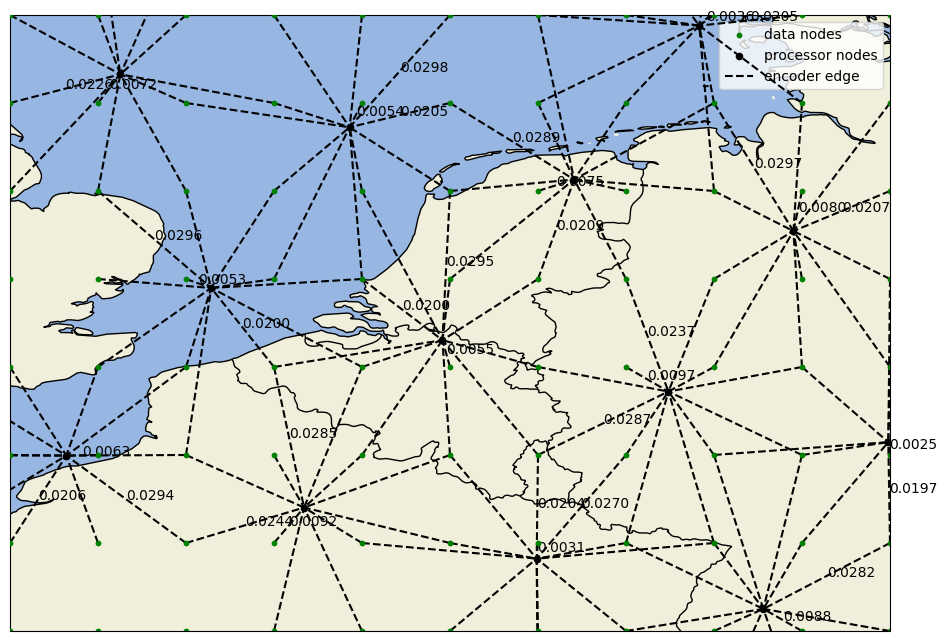

In [110]:

fig, ax = plt.subplots(1, 1, subplot_kw={"projection":ccrs.PlateCarree()}, figsize=(12,8))

ax.scatter(np.rad2deg(graph["data"]["x"][:,0]), np.rad2deg(graph["data"]["x"][:,1]), s=10, c="green",label="data nodes", zorder=20)
ax.scatter(np.rad2deg(graph["processor"]["x"][:,0]), np.rad2deg(graph["processor"]["x"][:,1]), s=20, c="black", label="processor nodes", zorder=20)
encoder_edges = graph[("data","to","processor")]["edge_index"]
cnt = 0
for i in range(encoder_edges.shape[1]):

    i_data = encoder_edges[0,i]
    i_processor = encoder_edges[1,i]
    lon_data, lat_data = (np.rad2deg(graph["data"]["x"][i_data,:]) + 180) % 360 -180
    lon_proc, lat_proc = (np.rad2deg(graph["processor"]["x"][i_processor,:]) + 180) %360 - 180
    lon_text, lat_text = (np.mean([lon_data,lon_proc]), np.mean([lat_data, lat_proc]))
    if lon_proc > 0 and lon_proc < 10 and lat_proc > 48 and lat_proc < 55:                                 
        im = ax.plot(
            [lon_data, lon_proc],
            [lat_data, lat_proc],
            c="black",
            ls="--",
            zorder=15
        )
        if cnt % 4 == 0 and lon_text > 0 and lon_text < 10 and lat_text > 48 and lat_text < 55:
            ax.text(x=lon_text,y=lat_text,s=f"{graph[("data","to","processor")]["edge_length"][i][0]:.4f}")
        cnt += 1
im[0].set_label("encoder edge")
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_extent([0,10,48,55])
ax.legend(loc="upper right")